In [137]:
%load_ext autoreload
%autoreload 2

In [ ]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

In [138]:
from datetime import datetime
import pandas_datareader.data as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
import matplotlib.ticker as ticker #used for changing tick spacing
from finta import TA
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import time
import plotly.express as px
import sys
import os

In [169]:
from data_prep import train_test_split_preparation as data_split
from data_prep import add_technical_indicators
from data_prep import on_balance_volume_creation

In [43]:
df = pd.read_csv('US1.F_200620_210620.csv')

In [44]:
df.head()

<TICKER>  <PER>    <DATE>  <TIME>  <OPEN>  <HIGH>  <LOW>  <CLOSE>  <VOL>
0    US1.F      1  20200622  163100    6.26    6.26  6.220     6.25  11932
1    US1.F      1  20200622  163200    6.26    6.26  6.240     6.25   2620
2    US1.F      1  20200622  163300    6.25    6.25  6.230     6.23  24968
3    US1.F      1  20200622  163400    6.22    6.23  6.210     6.21  13930
4    US1.F      1  20200622  163500    6.20    6.20  6.165     6.18  26957

In [45]:
df.pop('<TICKER>')
df.pop('<PER>')

0        1
1        1
2        1
3        1
4        1
        ..
77462    1
77463    1
77464    1
77465    1
77466    1
Name: <PER>, Length: 77467, dtype: int64

In [46]:
df.head()

<DATE>  <TIME>  <OPEN>  <HIGH>  <LOW>  <CLOSE>  <VOL>
0  20200622  163100    6.26    6.26  6.220     6.25  11932
1  20200622  163200    6.26    6.26  6.240     6.25   2620
2  20200622  163300    6.25    6.25  6.230     6.23  24968
3  20200622  163400    6.22    6.23  6.210     6.21  13930
4  20200622  163500    6.20    6.20  6.165     6.18  26957

In [47]:
df.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']

In [48]:
df.head()

Date    Time  Open  High    Low  Close  Volume
0  20200622  163100  6.26  6.26  6.220   6.25   11932
1  20200622  163200  6.26  6.26  6.240   6.25    2620
2  20200622  163300  6.25  6.25  6.230   6.23   24968
3  20200622  163400  6.22  6.23  6.210   6.21   13930
4  20200622  163500  6.20  6.20  6.165   6.18   26957

In [49]:
# df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
# df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
# df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
# df['Date'] = pd.to_datetime(df['Date'], unit='s')
df['Date'] = pd.to_datetime(df['Date'], format = "%Y%m%d").dt.strftime('%Y-%m-%d') 

In [116]:
df.head()

Date    Time  Open  High    Low  Close  Volume
0  2020-06-22  163100  6.26  6.26  6.220   6.25   11932
1  2020-06-22  163200  6.26  6.26  6.240   6.25    2620
2  2020-06-22  163300  6.25  6.25  6.230   6.23   24968
3  2020-06-22  163400  6.22  6.23  6.210   6.21   13930
4  2020-06-22  163500  6.20  6.20  6.165   6.18   26957

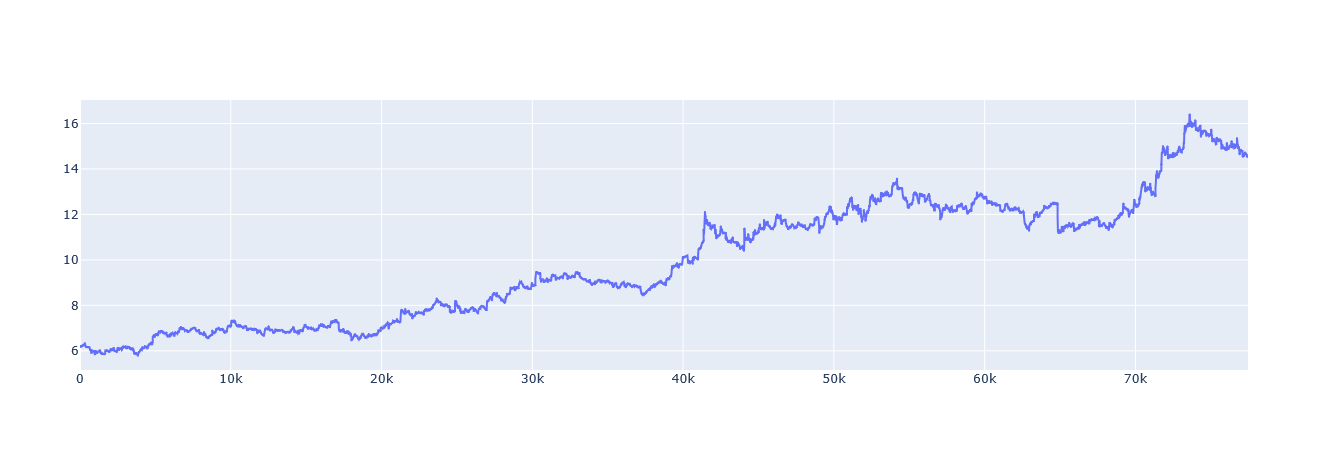

In [51]:
trace0 = go.Scatter(x=df.index, y=df.Close)
data = [trace0]
py.iplot(data)

In [52]:
fig_size = plt.rcParams["figure.figsize"] #loads current figure size
print('old size:',fig_size) #prints the size
fig_size[0] = 15 #sets the X size to 15
fig_size[1] = 8 #sets the Y size to 8
plt.rcParams["figure.figsize"] = fig_size #sets this numbers to the new size
fig_size = plt.rcParams["figure.figsize"] #loads the figure size for checking
print ('new size:',fig_size) #prints the figure size

old size: [6.0, 4.0]
new size: [15.0, 8.0]


Text(0.5, 0, 'Date')

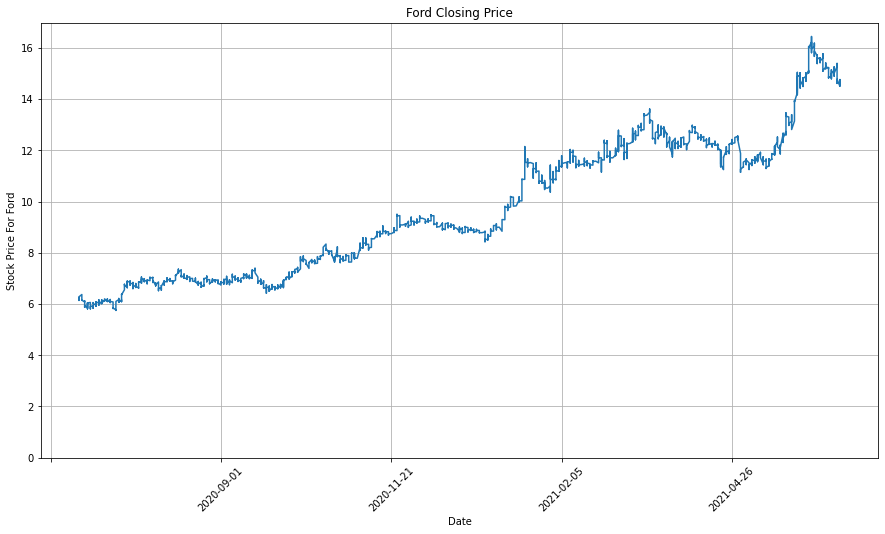

In [212]:
# x = [datetime.strptime(d,'%Y-%m-%d').date() for d in v.index.values] #convert date to something python understands
x = df.Date
y = df.Close #plots which ever catagory you entered above

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) #display the date properly
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) #x axis tick every 60 days
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100)) # sets y axis tick spacing to 100

plt.plot(x,y) #plots the x and y
plt.grid(True) #turns on axis grid
plt.ylim(0) #sets the y axis min to zero
plt.xticks(rotation=45,fontsize = 10) #rotates the x axis ticks 90 degress and font size 10
plt.title('Ford Closing Price') #prints the title on the top
plt.ylabel('Stock Price For Ford') #labels y axis
plt.xlabel('Date') #labels x axis


### Simple LSTM on raw close price

In [170]:
stock_df = df
stock_df.head()

Date    Time  Open  High    Low  Close  Volume
0  2020-06-22  163100  6.26  6.26  6.220   6.25   11932
1  2020-06-22  163200  6.26  6.26  6.240   6.25    2620
2  2020-06-22  163300  6.25  6.25  6.230   6.23   24968
3  2020-06-22  163400  6.22  6.23  6.210   6.21   13930
4  2020-06-22  163500  6.20  6.20  6.165   6.18   26957

In [171]:
stock_df = stock_df.reset_index(drop=True)

In [172]:
new_df2 = on_balance_volume_creation(stock_df)
new_df2

Close  On_Balance_Volume
0       6.250          14.237433
1       6.250          14.237433
2       6.230          14.220924
3       6.210          14.211594
4       6.180          14.193287
...       ...                ...
77462  14.535          16.706832
77463  14.535          16.706832
77464  14.550          16.708493
77465  14.540          16.706293
77466  14.520          16.702765

[77467 rows x 2 columns]

In [173]:
new_df2 = add_technical_indicators(new_df2, stock_df=stock_df)
new_df2

Close  On_Balance_Volume  Exponential_moving_average   BB_UPPER  \
0       6.250          14.237433                    6.250000   6.250000   
1       6.250          14.237433                    6.250000   6.250000   
2       6.230          14.220924                    6.241803   6.264897   
3       6.210          14.211594                    6.231030   6.269327   
4       6.180          14.193287                    6.215850   6.275179   
...       ...                ...                         ...        ...   
77462  14.535          16.706832                   14.539150  14.562634   
77463  14.535          16.706832                   14.538320  14.561787   
77464  14.550          16.708493                   14.540656  14.562622   
77465  14.540          16.706293                   14.540525  14.561787   
77466  14.520          16.702765                   14.536420  14.562005   

       BB_MIDDLE   BB_LOWER  
0       6.250000   6.250000  
1       6.250000   6.250000  
2       6.241803   6.218709  
3       6.231030   6.192733  
4       6.215850   6.156520  
...          ...        ...  
77462  14.542250  14.521866  
77463  14.541500  14.521213  
77464  14.542000  14.521378  
77465  14.541500  14.521213  
77466  14.540000  14.517995  

[77467 rows x 6 columns]

In [148]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [150]:
train_percent = 0.7
val_percent = 0.2
history_points = 21

X_train, y_train, X_val, y_val, X_test, y_test, y_reverse_normaliser = data_split(new_df2, train_percent, val_percent, history_points=history_points)

In [151]:
# convering to torch

X_train = torch.from_numpy(X_train).type(torch.Tensor).to(device)
X_val = torch.from_numpy(X_val).type(torch.Tensor).to(device)
X_test = torch.from_numpy(X_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_val = torch.from_numpy(y_val).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

In [152]:
print('X_train.shape = ',X_train.shape)
print('X_val.shape = ',X_val.shape)
print('X_test.shape = ',X_test.shape)
print('y_train.shape = ',y_train.shape)
print('y_val.shape = ',y_val.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  torch.Size([54205, 21, 6])
X_val.shape =  torch.Size([15472, 21, 6])
X_test.shape =  torch.Size([7727, 21, 6])
y_train.shape =  torch.Size([54205, 1])
y_val.shape =  torch.Size([15472, 1])
y_test.shape =  torch.Size([7727, 1])


We have our data ready.

Now for the model:

### LSTM

In [164]:
input_dim = 6
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [165]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [166]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [167]:
train_loss = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    
    with torch.no_grad():
        ## TODO: MODEL EVAL
        y_val_pred = model(X_val)
        val_loss[t] = criterion(y_val_pred, y_val)
    
    print('Epoch {}, Train MSE {:.2f}, Val MSE {:.2f}'.format(t, loss.item(), val_loss[t]))
    train_loss[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch 0, Train MSE 0.39, Val MSE 152.57
Epoch 1, Train MSE 0.21, Val MSE 147.55
Epoch 2, Train MSE 0.07, Val MSE 140.97
Epoch 3, Train MSE 0.06, Val MSE 130.41
Epoch 4, Train MSE 0.06, Val MSE 130.22
Epoch 5, Train MSE 0.03, Val MSE 133.51
Epoch 6, Train MSE 0.03, Val MSE 136.21
Epoch 7, Train MSE 0.04, Val MSE 137.46
Epoch 8, Train MSE 0.04, Val MSE 137.40
Epoch 9, Train MSE 0.03, Val MSE 136.33
Epoch 10, Train MSE 0.02, Val MSE 134.48
Epoch 11, Train MSE 0.01, Val MSE 132.19
Epoch 12, Train MSE 0.01, Val MSE 129.95
Epoch 13, Train MSE 0.01, Val MSE 128.41
Epoch 14, Train MSE 0.01, Val MSE 128.03
Epoch 15, Train MSE 0.00, Val MSE 128.60
Epoch 16, Train MSE 0.00, Val MSE 129.60
Epoch 17, Train MSE 0.01, Val MSE 130.43
Epoch 18, Train MSE 0.01, Val MSE 130.50
Epoch 19, Train MSE 0.01, Val MSE 129.77
Epoch 20, Train MSE 0.00, Val MSE 128.67
Epoch 21, Train MSE 0.00, Val MSE 127.66
Epoch 22, Train MSE 0.00, Val MSE 127.14
Epoch 23, Train MSE 0.00, Val MSE 127.26
Epoch 24, Train MSE 0.00, 

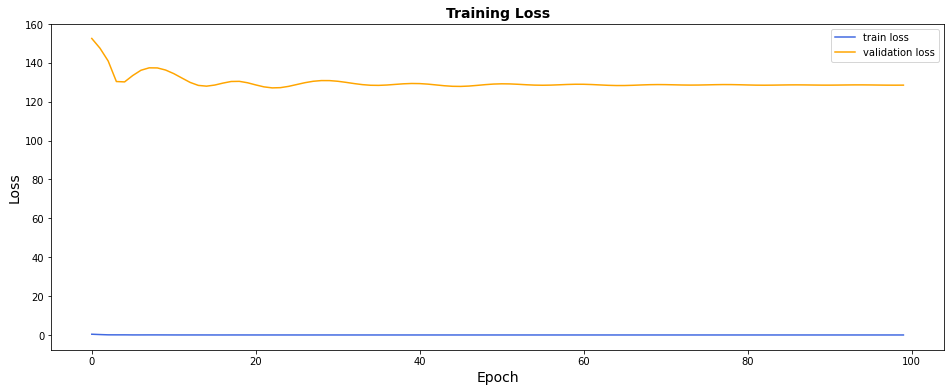

In [180]:
fig = plt.subplots()
ax = sns.lineplot(data=train_loss, color='royalblue', label='train loss')
ax2 = sns.lineplot(data=val_loss, color='orange', label='validation loss')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

Text(0.5, 0, 'Epoch')

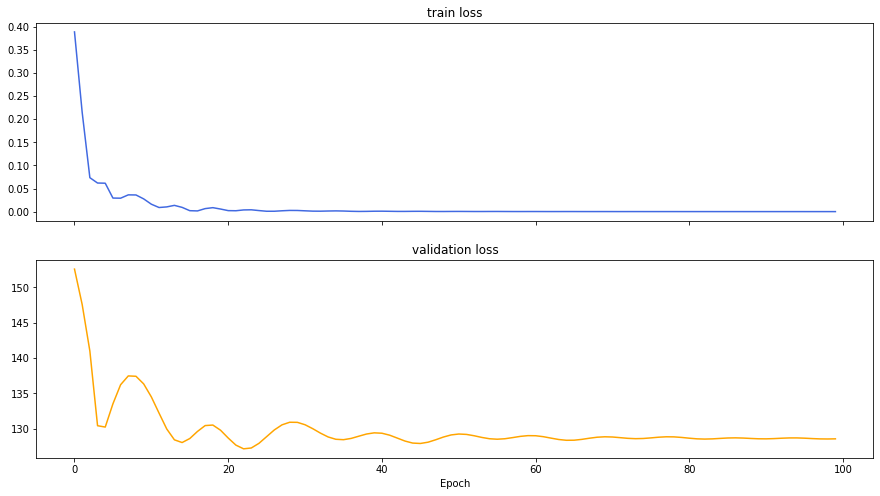

In [184]:
fig, axes = plt.subplots(2, 1, sharex=True)

# Bulbasaur
sns.lineplot(data=train_loss, color='royalblue', ax=axes[0])
axes[0].set_title('train loss')

# Charmander
ax2 = sns.lineplot(data=val_loss, color='orange', ax=axes[1])
axes[1].set_title('validation loss')

plt.xlabel('Epoch')

In [186]:
train_predict = pd.DataFrame(y_reverse_normaliser.inverse_transform(y_train_pred.detach().cpu().numpy()))
train_original = pd.DataFrame(y_reverse_normaliser.inverse_transform(y_train.detach().cpu().numpy()))
print("train predict shape: ", train_predict.shape)
print("train original shape: ", train_original.shape)

train predict shape:  (54205, 1)
train original shape:  (54205, 1)


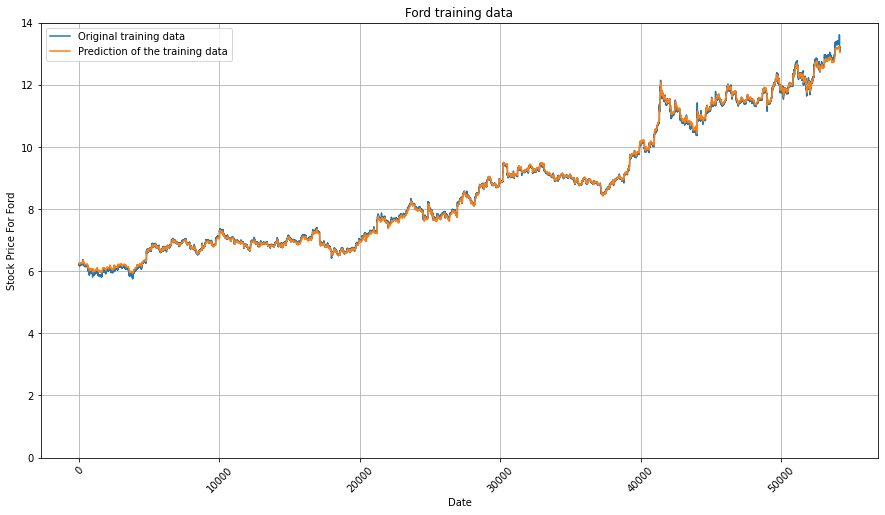

In [187]:
# x = [datetime.strptime(d,'%Y-%m-%d').date() for d in v.index.values] #convert date to something python understands
# x = v.index
# y = v.Close #plots which ever catagory you entered above

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y')) #display the date properly
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) #x axis tick every 60 days
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100)) # sets y axis tick spacing to 100

plt.plot(train_original.index,train_original.values, label="Original training data") #plots the x and y
plt.plot(train_predict.index,train_predict.values, label="Prediction of the training data") #plots the x and y
plt.grid(True) #turns on axis grid
plt.ylim(0) #sets the y axis min to zero
plt.xticks(rotation=45,fontsize = 10) #rotates the x axis ticks 90 degress and font size 10
plt.title('Ford training data') #prints the title on the top
plt.ylabel('Stock Price For Ford') #labels y axis
plt.xlabel('Date') #labels x axis
plt.legend()


Computing the test prediction and plotting it:

In [189]:
y_pred = model(X_test)
test_predict = pd.DataFrame(y_reverse_normaliser.inverse_transform(y_pred.detach().cpu().numpy()))
test_original = pd.DataFrame((y_test.detach().cpu().numpy()))

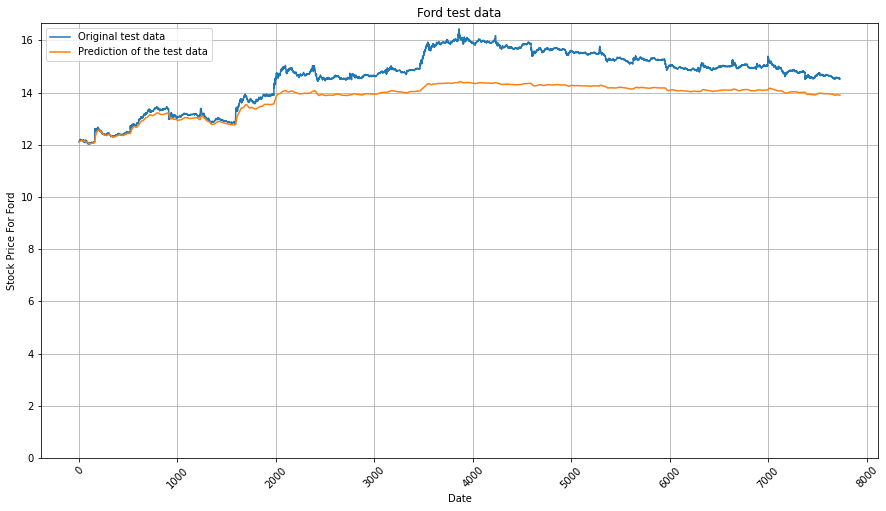

In [190]:
plt.plot(test_original.index, test_original.values, label="Original test data") #plots the x and y
plt.plot(test_predict.index,test_predict.values, label="Prediction of the test data") #plots the x and y
plt.grid(True) #turns on axis grid
plt.ylim(0) #sets the y axis min to zero
plt.xticks(rotation=45,fontsize = 10) #rotates the x axis ticks 90 degress and font size 10
plt.title('Ford test data') #prints the title on the top
plt.ylabel('Stock Price For Ford') #labels y axis
plt.xlabel('Date') #labels x axis
plt.legend()

In [113]:
mean_squared_error(test_original.values, test_predict.values)

0.71980375

In [117]:
test_predict

0
0      12.746579
1      12.748931
2      12.750760
3      12.753509
4      12.755577
...          ...
23215  13.362903
23216  13.362564
23217  13.362259
23218  13.362370
23219  13.362190

[23220 rows x 1 columns]

In [100]:
# test_predict = pd.DataFrame(y_reverse_normaliser.inverse_transform(y_pred.detach().numpy()))
# test_original = pd.DataFrame((y_test.detach().numpy()))
concat_df = pd.concat([test_predict, test_original], axis=1)
concat_df.columns = ['predict', 'training']

In [101]:
concat_df.head()

predict  training
0  12.746579    13.215
1  12.748931    13.200
2  12.750760    13.230
3  12.753509    13.215
4  12.755577    13.210

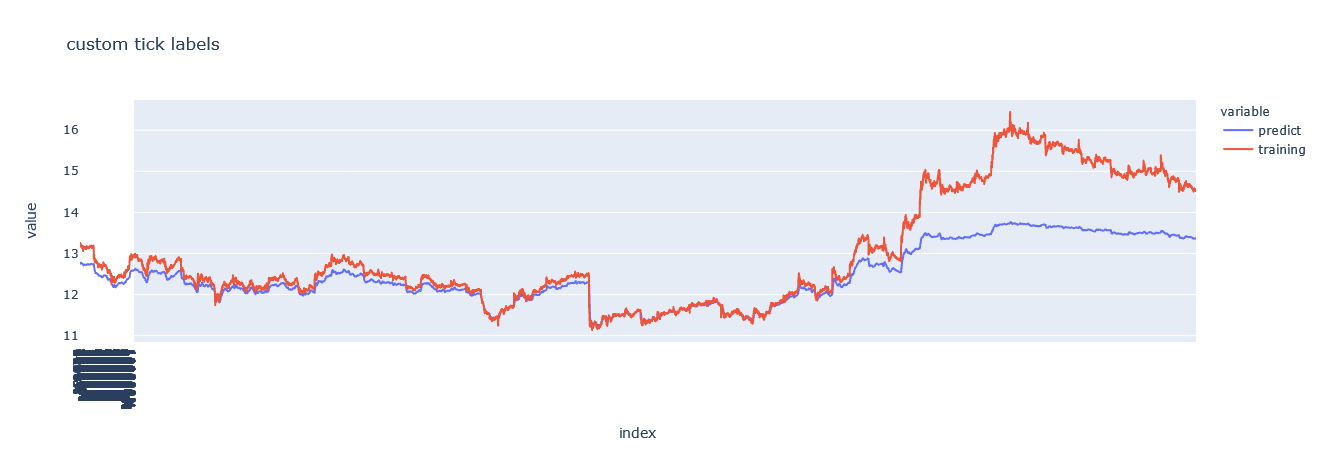

In [108]:
fig = px.line(concat_df, x=concat_df.index, y=['predict', 'training'],
              title='custom tick labels')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()